In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [58]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

In [59]:
from vecbool_data_gen import *
from train_vecbool_model import *

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
embedding = nn.Embedding(10, 3)

input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 0.3743, -1.2284, -1.4869],
         [-0.8054, -0.6420,  0.0416],
         [ 1.5611, -1.2919, -1.0816],
         [ 1.3061,  0.5731, -1.8416]],

        [[ 1.5611, -1.2919, -1.0816],
         [-0.5770, -0.3827, -2.2903],
         [-0.8054, -0.6420,  0.0416],
         [ 0.2623, -0.2265,  0.6852]]], grad_fn=<EmbeddingBackward>)

In [62]:
cont_x = torch.tensor(np.random.uniform(0, 5, size=(10, 2))).float()

cat_x = torch.tensor(np.random.randint(2, size=(10, 4))).long()
print(cont_x.shape)
print(cat_x.shape)

torch.Size([10, 2])
torch.Size([10, 4])


In [63]:
embedding = nn.Embedding(8, 12)
print(cat_x)
embedded = embedding(cat_x)
print(embedded)

tensor([[0, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [1, 1, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 1, 1, 1],
        [0, 1, 0, 1]])
tensor([[[ 0.3778, -1.1228, -1.5748, -0.1916,  2.2243,  0.9270,  1.2192,
          -1.2059,  0.3278, -0.2618,  1.0322, -0.4914],
         [ 0.3778, -1.1228, -1.5748, -0.1916,  2.2243,  0.9270,  1.2192,
          -1.2059,  0.3278, -0.2618,  1.0322, -0.4914],
         [ 0.5321, -0.2617, -0.8757, -0.9878, -0.1060,  0.6551,  0.6568,
          -2.1082, -0.3583, -0.2275,  0.4714, -0.8801],
         [ 0.3778, -1.1228, -1.5748, -0.1916,  2.2243,  0.9270,  1.2192,
          -1.2059,  0.3278, -0.2618,  1.0322, -0.4914]],

        [[ 0.3778, -1.1228, -1.5748, -0.1916,  2.2243,  0.9270,  1.2192,
          -1.2059,  0.3278, -0.2618,  1.0322, -0.4914],
         [ 0.5321, -0.2617, -0.8757, -0.9878, -0.1060,  0.6551,  0.6568,
          -2.1082, -0.3583, -0.2275,  0.4714, -0.8801],
   

## Data Exploration

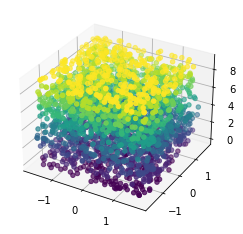

In [64]:
X_train, y_train = get_train_data(3000)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()

train_data = []
for i in range(len(X_train)):
#     train_data.append([X_train[i], X_train_true_labels[i]])
    train_data.append([X_train[i], y_train[i]])
        
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train, c=y_train)

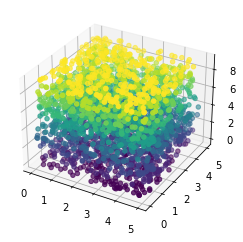

In [65]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_train, cache["X_train_mean"], cache["X_train_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train, c=y_train)

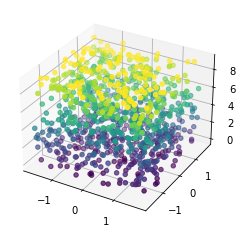

In [66]:
X_test, y_test = get_test_splitA(1000)

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
        
ax = plt.axes(projection='3d')
ax.scatter3D(X_test[:, 0], X_test[:, 1], y_test, c=y_test)

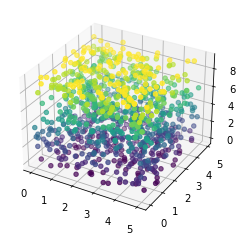

In [67]:
# Plotting the testing data, unstandardized
X_test_orig = unstandardize_data(X_test, cache["X_testA_mean"], cache["X_testA_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_test_orig[:, 0], X_test_orig[:, 1], y_test, c=y_test)

In [85]:
print(cache)

{'X_train_mean': array([2.52003081, 2.48903697]), 'X_train_std': array([1.45224694, 1.42666906]), 'X_testA_mean': array([2.60440469, 2.53635034]), 'X_testA_std': array([1.45672958, 1.46447607])}


## Helper Methods

In [99]:
def get_num_correct(preds, labels):
    pred = preds.max(1, keepdim=True)[1]
    correct = pred.eq(labels.view_as(pred)).sum().item()
    return correct

## Training Model

In [107]:
emb_dims = [2*boolvec_dim, 8*boolvec_dim]
# emb_dims = [0, 0]
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [108]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[64, 256, 512, 320, 256, 128, 64, 32, 20], \
               output_size=num_classes, hidden_drop_p=0, batch_flag=False)

n_epochs = 100000
loss_values = []
acc_values = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

t = tqdm(range(1, n_epochs+1), miniters=100)
for epoch in t:
    total_loss = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:, :2].float()
        cat_x = inputs[:, 2].long()
        
        optimizer.zero_grad()
        
        preds = model(cont_x, cat_x)
        
        loss = criterion(preds, labels)
        total_loss += loss.item()
        correct += get_num_correct(preds, labels)
        
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss/num_batches
    acc = correct/len(train_data)
    t.set_description(f"-----Epoch: {epoch}/{n_epochs}, Loss: {total_loss/num_batches}, Accuracy: {acc}-----")
    loss_values.append(epoch_loss)
    acc_values.append(acc)

-----Epoch: 13092/100000, Loss: 0.05877398264904817, Accuracy: 0.977-----:  13%|█▎        | 13092/100000 [1:08:43<6:35:35,  3.66it/s]              IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

-----Epoch: 15766/100000, Loss: 0.12641014407078424, Accuracy: 0.954-----:  16%|█▌        | 15765/100000 [1:21:58<6:17:19,  3.72it/s]              IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

-----Epoch: 19362/100000, Loss: 0.1056209784001112, Accu

KeyboardInterrupt: 

Text(0, 0.5, 'Training loss')

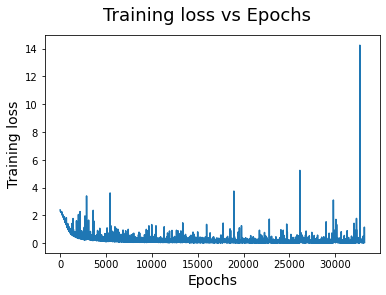

In [110]:
plt.plot(np.array(np.arange(0, 33187)), loss_values)
plt.suptitle('Training loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training loss', fontsize=14)

Text(0, 0.5, 'Training accuracy')

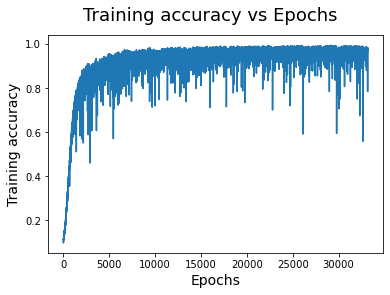

In [112]:
plt.plot(np.array(np.arange(0, 33187)), acc_values)
plt.suptitle('Training accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training accuracy', fontsize=14)

## Model Testing